Current Directory : /Users/yukako/WorkSpace/CreativeCoding2019/SimilarImageSearch
Inpute Image : ../scratch/splites/project1/278328/0.png
Hash Value of Input Image >>> [f792c361b9b68328]



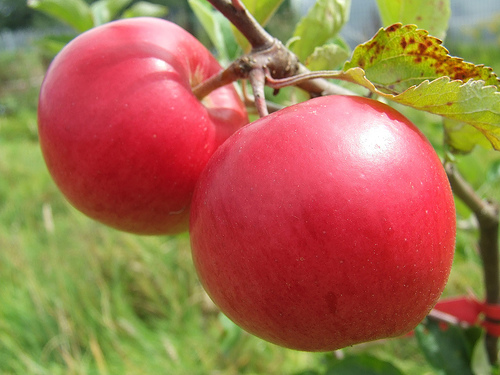

Project Path : ../scratch/splites/project1/
Project ID : 278328

Searched Images (20files) are ...
['../scratch/splites/project1/262284/5.png',
 '../scratch/splites/project1/262284/6.png',
 '../scratch/splites/project1/262284/2.png']
Similar images are ...
[('../scratch/splites/project1/263857/4.png', 24),
 ('../scratch/splites/project1/266490/4.png', 26),
 ('../scratch/splites/project1/266490/10.png', 28)]
Output : 


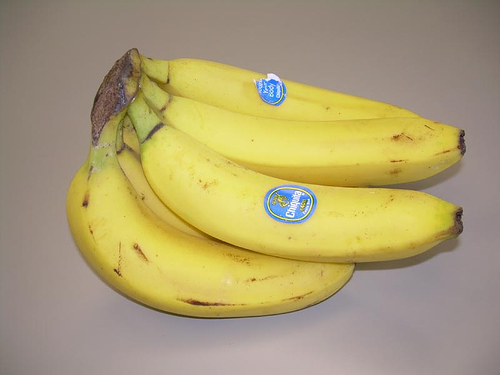

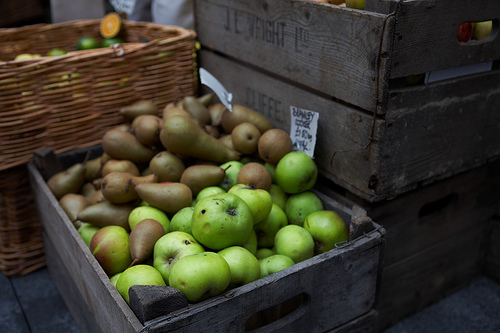

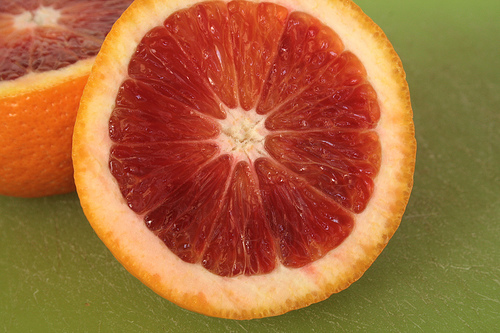

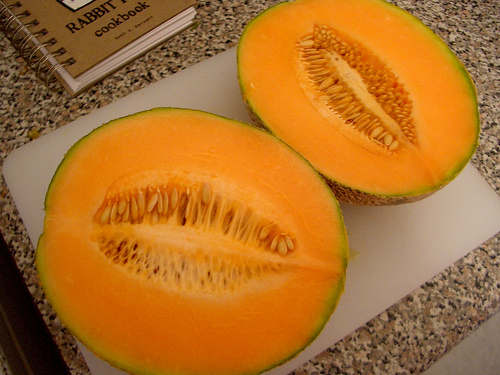

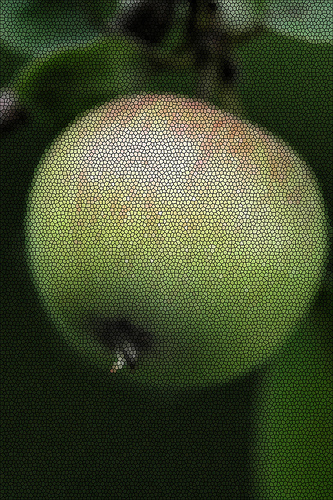

e_time:1.0482509136199951[s]


In [3]:
# 2019.01.15
# Python v3.7.2 (Jupyter Notebook)
#
# 1. Input画像ファイル読み込み (パスをプログラムにべた書き) 
# 2. Input画像のハッシュ値算出
# 3. 他のプロジェクトIDのフォルダに入っている画像ファイルまとめて読み込み
# 4. 他の画像ファイルのハッシュ値算出
# 5. Input画像のハッシュ値と他の画像のハッシュ値の差分のリスト作成
# 6. 差分のリストを降順でソート
# 7. 上位5位(任意)をコンソールに表示
#
# TODO:
# - jpg対応?
# - 高速化、精度向上
#     - 別のハッシュ値算出アルゴリズム試してみる?
#     - ファイル探索処理工夫できないか確認
#     - サイズの影響が強いかどうか調べる
# - まったく同じ画像を除外などする工夫
# - GUI化
# - Input画像とOutput画像のサイズとかの情報取得する

from PIL import Image, ImageFile
import numpy as np
import imagehash
import os
from glob import glob
import re
import pprint
from collections import OrderedDict
from IPython.display import display_png
import time

start = time.time()

# ---------------------------------
# Configrations and grobal variables
# ---------------------------------
# 表示する類似画像の個数
showImgNum = 5
# サイズの大きな画像をスキップしない
ImageFile.LOAD_TRUNCATED_IMAGES = True


# ---------------------------------
# Load an input image from  and Calculate the hash value
# ---------------------------------
# inputImg = "../scratch/splites/project1/262284/9.png"
inputImg = "../scratch/splites/project1/278328/0.png"
inputHash = imagehash.phash(Image.open(inputImg))
print("Current Directory : " + os.getcwd())
print("Inpute Image : " + inputImg + "\nHash Value of Input Image >>> [" + str(inputHash) + "]\n")
display_png(Image.open(inputImg))

# ---------------------------------
# Calculate hash values of other images and difference values
# ---------------------------------
# input画像のパスから、input画像が所属するProjectIDの文字列、他のProjectIDフォルダが所属するプロジェクトフォルダのパスを取得
# 正規表現メモ: 任意の1桁以上の数値\d{1,}
path_inputPrjID = re.sub("\d{1,}.png", "", inputImg).strip("/") # "../scratch/splites/project1/262284
# 正規表現メモ: 任意の英数字以外[\W]や英数字[\w]の0回以上の繰り返し*と記号/にマッチする部分を取り除く
prjID = re.sub("[\W\w]*/", "", path_inputPrjID) # "262284"
path_prj = path_inputPrjID.strip(prjID) # "../scratch/splites/project1/" 便宜上最後に"/"入れたままなので注意
print("Project Path : " + path_prj + "\nProject ID : " + prjID + "\n")

# すべての画像のパス取得
pathList = glob(path_prj + "*/*.png") # 1つめの*はProjectIDをワイルドカードで指定(プロジェクトIDのフォルダごとに回すよりよさそう)
# input画像が所属するProjectIDはハッシュ値算出から取り除く
pathList = [path for path in pathList if prjID not in path] # 内包表記 [繰り返しindex for 繰り返しindex in 検索元]と[if 特定の文字列 in 検索元]
print("Searched Images (" + str(len(pathList)) + "files) are ...")
pprint.pprint(pathList[0:3]) # 0から(4-1)番目までを取得

# input画像以外のすべての画像のハッシュ値を算出
hashList = [imagehash.phash(Image.open(img)) for img in pathList]
# difに2つの画像のハッシュ値の差分を入れる
difList = [abs(inputHash - hashVal) for hashVal in hashList] # intのlistで帰る
# print(hashList[0])
# print(difList)
# print(len(difList))


# ---------------------------------
# Create dictionary from other image paths list and difference values list
# ---------------------------------
# Keyがpath、Valueがdifで順序を保った辞書を作る
dic = OrderedDict((pathList[i], difList[i]) for i in range(len(pathList)))
# print(k, v) for k, v in dic.items() # 辞書型の確認はこの方法のみ

# Value(difList(ハッシュ値差分)の値)で降順でソート
# lambdaは無名関数の定義で用いる決まり文句. "x[1]を返す無名の関数をkeyパラメータに入れる"的な意味らしい
# https://qiita.com/n10432/items/e0315979286ea9121d57
sortedDic = sorted(dic.items(), key = lambda x:x[1]) # tupleのlistで帰ってくる
print("Similar images are ...")
pprint.pprint(sortedDic[0:3])


# ---------------------------------
# Show similar images
# ---------------------------------
print("Output : ")
# key(パス)、0列目を取りだすのでsortedDic[i][0]の[0]
[display_png(Image.open(sortedDic[i][0])) for i in range(showImgNum)]


e_time = time.time() - start
print ("e_time:{0}".format(e_time) + "[s]")
